In [2]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd
import configs

device = 'cpu'

In [3]:
def format_model_name(key):
    if key == 'rnn_dynamiclr':
        raise ValueError("Invalid key.")
        return 'RNN with Dynamic LR'
    elif key == 'rnn_fixedlr':
        raise ValueError("Invalid key.")
        return 'RNN with Fixed LR'
    elif key == 'rnn_fixedlr_alpha':
        return 'RNN with Learned Alpha'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [4]:
def format_dset_name(key):
    if 'discrete_uncorr/pval50/' in key:
        return 'Uncorr.:\n50% Sparse'
    elif 'discrete_uncorr/pval80/' in key:
        return 'Uncorr.:\n80% Sparse'
    elif 'discrete_uncorr/pval95/' in key:
        return 'Uncorr.:\n95% Sparse'
    elif 'discrete_corr/pval50_sigma1.25/' in key:
        return 'Corr.:\n50% Sparse'
    elif 'discrete_corr/pval80_sigma1.25/' in key:
        return 'Corr.:\n80% Sparse'
    elif 'discrete_corr/pval95_sigma1.25/' in key:
        return 'Corr.:\n95% Sparse'
    elif 'discrete_corr/sparse_sigma1.25/' in key:
        return 'Corr.:\nLocalized'
    else:
        return 'Unknown'

In [5]:
hue_order = [
    'Linear',
    'RNN with Learned Alpha',
    'MLP with Replay Buffer',
    #'RNN with Fixed LR', 'RNN with Dynamic LR',
    ]

# Collect aggregate metrics

In [7]:
root_dir = "../trained_models/"
root_dir = '/media/chingf/EXTRA SPACE/trained_models_copy/'
dset_dirs = [
    '03_td_discrete_uncorr/pval50/',
    '03_td_discrete_uncorr/pval80/',
    '03_td_discrete_uncorr/pval95/',
    '03_td_discrete_corr/pval50_sigma1.25/',
    '03_td_discrete_corr/pval80_sigma1.25/',
    '03_td_discrete_corr/pval95_sigma1.25/',
    '03_td_discrete_corr/sparse_sigma1.25/',
    ]

gamma = 0.6

dsets = []
models = []
start_losses = []
time_to_elbows = []
final_losses = []

for dset_dir in dset_dirs:
    dset_gamma_dir = f'{root_dir}{dset_dir}{gamma}/'
    dset_name = format_dset_name(dset_dir)

    for model in os.listdir(dset_gamma_dir):
        model_dir = dset_gamma_dir + model + '/'
        try:
            model_name = format_model_name(model)
        except:
            continue # Not a directory we care about
        for _iter in os.listdir(model_dir):
            iter_dir = model_dir + _iter + '/'
            for file in os.listdir(iter_dir):
                if 'tfevents' not in file: continue
                tfevents_file = iter_dir + '/' + file
                event_acc = EventAccumulator(tfevents_file)
                event_acc.Reload()
                scalar_events = event_acc.Scalars('loss_train')
                values = np.array([event.value for event in scalar_events])
                steps = np.array([event.step for event in scalar_events])
                central_diffs = values[1:] + values[:-1] - 2*values[:-1]
                if values[0] > values[-1]: # decreasing
                    val95 = values[0] - abs(values[0] - values[-1])*0.95
                    time_to_95 = np.argwhere(values <= val95)[0][0]
                else: # increasing
                    val95 = values[-1] - abs(values[0] - values[-1])*0.95
                    time_to_95 = np.argwhere(values >= val95)[0][0]
                dsets.append(dset_name)
                models.append(model_name)
                start_losses.append(values[0])
                time_to_elbows.append(steps[time_to_95])
                #time_to_elbows.append(steps[np.argmax(central_diffs)])
                final_losses.append(values[-1])
                break

dsets = np.array(dsets)
models = np.array(models)
start_losses = np.array(start_losses)
time_to_elbows = np.array(time_to_elbows)
final_losses = np.array(final_losses)

FileNotFoundError: [Errno 2] No such file or directory: '/media/chingf/EXTRA SPACE/trained_models_copy/03_td_discrete_uncorr/pval50/0.6/'

# Make barplots

In [84]:
df = pd.DataFrame({
    'Dataset': dsets,
    'Model': models,
    'Start Loss': start_losses,
    'Time to Elbow': time_to_elbows/(dt_to_sec*60),
    'Final Loss': final_losses
    })

In [85]:
dset_fontsize = 12
xylabel_fontsize = 16

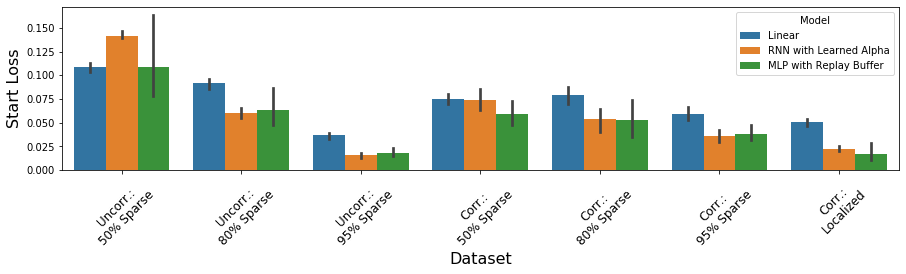

In [86]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Start Loss', hue='Model',
    ax=ax, data=df,
    hue_order=hue_order
    )
plt.ylabel('Start Loss', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.show()

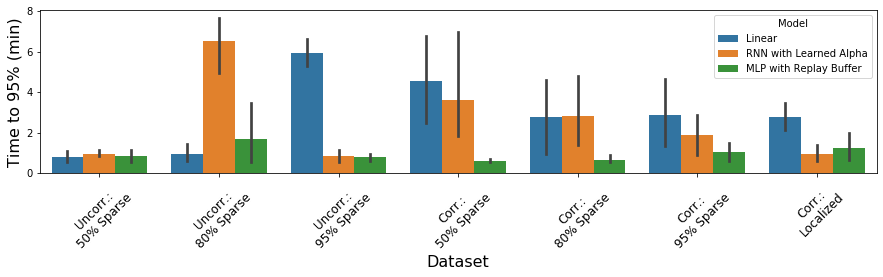

In [88]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Time to Elbow', hue='Model',
    ax=ax, data=df,
    hue_order=hue_order
    )
plt.ylabel('Time to 95% (min)', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.show()

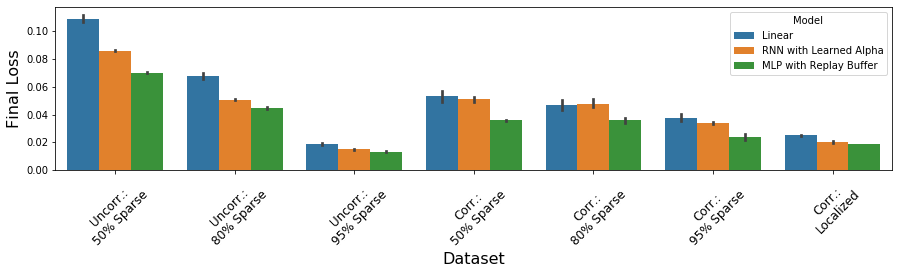

In [89]:
fig, ax = plt.subplots(figsize=(15, 3))
sns.barplot(
    x='Dataset', y='Final Loss', hue='Model',
    ax=ax, data=df,
    hue_order=hue_order
    )
plt.ylabel('Final Loss', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.show()